# Deterministic RBC model with search theory

Let us consider the following _two-dimensional deterministic model_:
\begin{eqnarray}
 v(k,n) = \max_{ n',k',c }
    \Bigg\{
     U(c) - G(n) &+& \beta v(k',n')
    \Bigg\}  \nonumber \\
     \mbox{ s.t. } \quad f(k,n)-k'-c-(1-n) &\geq& 0 \quad [\lambda] \nonumber \nonumber \\
     \quad \quad \quad (1-s)n + p(1-n) - n' &\geq& 0 \quad [\mu] \nonumber
\end{eqnarray}

The first-order conditions describing the dynamics of this system are given by:

\begin{align*}
k^{\theta} n^{1-\theta} - k' - c - 1 + n &= 0 \nonumber \\
(1-s)n + p(1-n) - n' &= 0  \nonumber \\
\beta (c')^{-1} \theta k^{ \theta - 1 } n^{ 1 - \theta } &= c^{ -1 }
\end{align*}

\begin{eqnarray}
 \beta \Bigg[ -(n')^{-1} + (c')^{-1} \Bigg( 1+(1-\theta)k^{\theta}n^{-\theta} \Bigg) + \mu'(1-s-p)  \Bigg]  = \mu \nonumber
\end{eqnarray}


Using the previous equations, we can compute the steady state values for the four variables, which is given by:
\begin{align*}
 k^* &= \left[ \frac{1}{\beta\theta\left( \frac{p}{s+p} \right)^{1-\theta}} \right]^{\frac{1}{\theta-1}} \\
 n^* &= \frac{p}{s+p} \\
 c^* &= (k^*)^{\theta} (n^*)^{1-\theta} - k^* - 1 + n^* \\
 \mu^* &= \frac{ \beta\left[ -(n^*)^{-1} + (c^*)^{-1} \left( 1+(1-\theta)(k^*)^{\theta}(n^*)^{-\theta} \right) \right] }{1-\beta(1-s-p)}
\end{align*}


The model is parameterized as follows:

| Parameter   | Value       |
| ----------- | ----------- |
| $\beta$     | 0.95        |
| $\theta$    | 0.2         |
| $s$         | 0.3         |
| $p$         | 0.75        |

This model is a modified version of [Merz, 1995](https://doi.org/10.1016/0304-3932(95)01216-8) and [Andolfatto, 1996](https://www.jstor.org/stable/2118258).

In [2]:
using Pkg
Pkg.add("Interpolations")
Pkg.add("Optim")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
    Updating `~/.julia/environments/v1.10/Project.toml`
  [429524aa] + Optim v1.9.4
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [3]:
using Optim

# Define parameters
β = 0.95         # Discount factor
θ = 0.36         # Capital share in Cobb-Douglas production function
s = 0.15         # Probability of staying employed
p = 0.15         # Probability of finding a job when unemployed
δ = 1 - (s + p)  # Depreciation rate
ϵ = 1e-4         # Convergence criterion for value function iteration

# Define utility function U(c)
U(c; σ=2.0) = c > 0 ? (c^(1 - σ) - 1) / (1 - σ) : -Inf

# Define cost function G(n)
G(n; γ=1.0) = γ * n^2 / 2

# Define production function f(k, n)
f(k, n; α=θ) = k^α * n^(1 - α)

# Discretize state space for capital (k) and labor (n)
k_grid = range(0.01, 10.0, length=100)
n_grid = range(0.01, 1.0, length=10)

# Initialize value function V(k, n) and policy functions
V = zeros(length(k_grid), length(n_grid))
g_k = zeros(length(k_grid), length(n_grid))
g_n = zeros(length(k_grid), length(n_grid))
g_c = zeros(length(k_grid), length(n_grid))

# Value function iteration
diff = Inf
iteration = 0
while diff > ϵ
    V_new = copy(V)
    for (ik, k) in enumerate(k_grid)
        for (in, n) in enumerate(n_grid)
            # Define the objective function for this iteration
            function objective(x)
                k_next, n_next, c = x
                -U(c) - G(n) - β * V_new[ik, in]
            end

            # Bounds for k_next, n_next, and c
            lower_bounds = [0.0, 0.0, 0.0]
            upper_bounds = [f(k, n), n, f(k, n)]

            # Initial guess - make sure it's strictly inside the bounds
            initial_x = [(lower_bounds[1] + upper_bounds[1]) / 2, (lower_bounds[2] + upper_bounds[2]) / 2, f(k, n) / 2]

            # Define box constraints and options
            inner_optimizer = GradientDescent()
            results = optimize(objective, lower_bounds, upper_bounds, initial_x, Fminbox(inner_optimizer))

            # Check the convergence status
            if Optim.converged(results)
                k_next_opt, n_next_opt, c_opt = Optim.minimizer(results)
                V[ik, in] = -Optim.minimum(results)
                g_k[ik, in] = k_next_opt
                g_n[ik, in] = n_next_opt
                g_c[ik, in] = c_opt
            else
                V[ik, in] = -Inf
            end
        end
    end

    # Check for convergence
    diff = maximum(abs.(V - V_new))
    iteration += 1
    println("Iteration $iteration, diff = $diff")
end

println("Value function iteration converged after $iteration iterations.")

# Output the policy functions
g_k, g_n, g_c



Iteration 1, diff = 98.99998333334779
Iteration 2, diff = 94.04998416668039
Iteration 3, diff = 89.3474849583464
Iteration 4, diff = 84.880110710429
Iteration 5, diff = 80.63610517490758
Iteration 6, diff = 76.60429991616218
Iteration 7, diff = 72.77408492035408
Iteration 8, diff = 69.13538067433637
Iteration 9, diff = 65.67861164061958
Iteration 10, diff = 62.39468105858862
Iteration 11, diff = 59.274947005659214
Iteration 12, diff = 56.311199655376186
Iteration 13, diff = 53.49563967260735
Iteration 14, diff = 50.82085768897707
Iteration 15, diff = 48.27981480452809
Iteration 16, diff = 45.865824064301705
Iteration 17, diff = 43.57253286108653
Iteration 18, diff = 41.39390621803227
Iteration 19, diff = 39.32421090713069
Iteration 20, diff = 37.3580003617742
Iteration 21, diff = 35.4901003436853
Iteration 22, diff = 33.715595326501216
Iteration 23, diff = 32.029815560176075
Iteration 24, diff = 30.428324782167238
Iteration 25, diff = 28.90690854305899
Iteration 26, diff = 27.461563115

([0.005 0.024527088707761414 … 0.0884259243972286 0.09527303589816237; 0.011889351770447568 0.05832223711030954 … 0.2102653841571305 0.2265469276063463; … ; 0.05989413772232758 0.2938057657980815 … 1.059238898814347 1.1412592666617591; 0.06011322173087064 0.29488046438047905 … 1.0631134400095612 1.1454338263838866], [0.005 0.06 … 0.445 0.5; 0.005 0.06 … 0.445 0.5; … ; 0.005 0.06 … 0.445 0.5; 0.005 0.06 … 0.445 0.5], [0.009999996666666332 0.04905417739515813 … 0.17685184871402282 0.1905460717093391; 0.023778698109329113 0.11664447418137176 … 0.4205307681441782 0.45309385502798954; … ; 0.1197882668753921 0.5876115315109619 … 2.118477797145058 2.282518532790533; 0.12022643488800756 0.5897609286756669 … 2.12622687953468 2.2908676522338793])

In [4]:
using Pkg
Pkg.add("Plots")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [5]:
using Plots
gr() # or plotly() if you prefer Plotly

# Select three fixed values of n for plotting against k
fixed_n_values = [n_grid[round(Int, length(n_grid)*i)] for i in [0.25, 0.5, 0.75]]

# Function to plot 2D graphs for fixed values of the other state dimension
function plot_2d_panels(k_grid, n_grid, policy_function, fixed_values, fixed_dim, title_prefix, y_label)
    p = []
    for val in fixed_values
        if fixed_dim == :n
            plot_data = policy_function[:, findfirst(n_grid .== val)]
            title = "$(title_prefix) for n=$(val)"
        elseif fixed_dim == :k
            plot_data = policy_function[findfirst(k_grid .== val), :]
            title = "$(title_prefix) for k=$(val)"
        end
        push!(p, plot(k_grid, plot_data, label=false, title=title, xlabel="k", ylabel=y_label))
    end
    plot(p..., layout=(length(fixed_values), 1), legend=false)
end


## !!! THE PLOTS INDICATE THAT THERE IS AN ISSUE !!! ##


plot_2d_panels (generic function with 1 method)

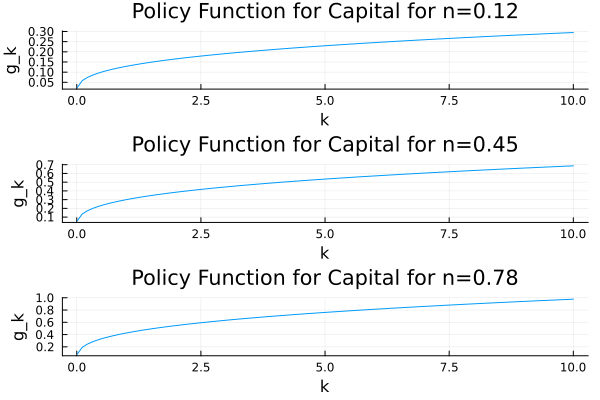

In [6]:
# Plotting for each policy function
plot_2d_panels(k_grid, n_grid, g_k, fixed_n_values, :n, "Policy Function for Capital", "g_k")

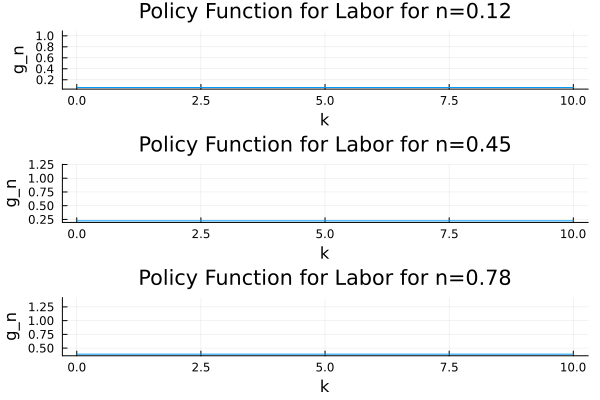

In [7]:
plot_2d_panels(k_grid, n_grid, g_n, fixed_n_values, :n, "Policy Function for Labor", "g_n")

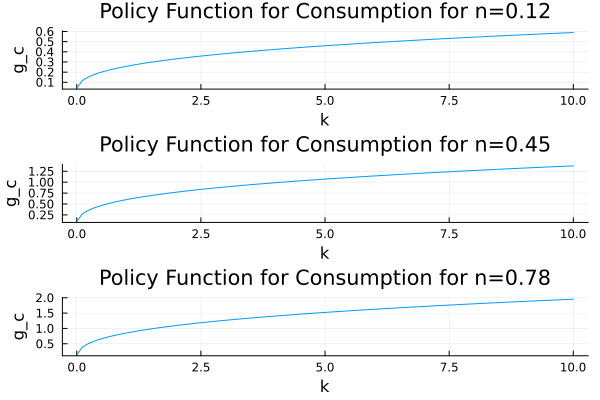

In [8]:
plot_2d_panels(k_grid, n_grid, g_c, fixed_n_values, :n, "Policy Function for Consumption", "g_c")